This notebook contains code snippets for reading in data from the SRT and for fitting curves to obtained data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
import glob

For the file grabbing, I assume that the files are named as follows: 

sun_X_Y, where X is either "el" for the elevation scan or "az" for the azimuth scan. Y is of the form ### or -###, where the ### is the offset in degrees (for example, an offset of 3 degrees would be 003) and the minus indicates a negative offset. This convention makes it so that, when sorted, the files will go in the order -001,-002,-003,...,-xyz,000,001,002,...,xyz. It's good to keep things like this in mind when making a naming convention, as it determines how you'll need to write loops to handle all your files.

In [3]:
data_folder = '/Users/kwhitle/Documents/Courses/501_Methods/Projects/Project3/Data/'

az_files = glob.glob(data_folder + "sun_az*") #This command grabs all of the files starting with "sun_az" in your data folder.
az_files.sort() #Notably, the "glob" function does NOT sort the list it creates, so we do that here with the "sort" command

Now that we have our files, it's time to pull out the relevant data! We know the format of the data files is three lines of text followed by one line containing all of the spectral data, repeating over the course of the observation. So, we just need to write up some code that will read in each file, skip over the lines that don't contain information we care about (i.e. all the ones that aren't the spectral data), and put the information we DO care about into an array so we can use it later.

In [9]:
az_spectra = [] # Create an empty array to later hold each of the spectra from the azimuthal scans

for az_file in az_files: #Pull each individual filename from the list of azimuth files
    
    with open(az_file) as az_data: #This opens up the file and puts each line into a list called az_data
        
        spectrum_rows = []    # We create a new empty list to put the rows with our spectral data into.
        
        for j, row in enumerate(az_data, start=1): # enumerate() works a lot like range(). You get an index (j, here) which is iterated over, but you also get an object (row) corresponding to the items in the list you're iterating over (that is, inside this loop, row is the same as az_data[j])
            if j%4 == 0: # The operator "%" is called the modulus. It returns the remainder of a division (e.g. 6%4=2). So, by checking when j%4 is zero, we get every fourth row in the data (which is where our spectral data is).
                spectrum_rows.append(row) # Throw every fourth row into our list of spectral data.
                
        tot_spectrum = np.zeros(1024) #Create an array of 1024 0's.
        for row in spectrum_rows: 
            temp_spec = row.split(' ') # Our rows are actually strings. To break them up, we use the split() command, which splits a string into a list by grabbing each segment separated by the delimiter you put in the parentheses (e.g. If you do 'abc def ghi'.split(' '), you'll get the list [abc,def,ghi])
            spec = [] # Create an empty list to hold the spectral data
            for val in temp_spec: # Iterate over the elements of your split list.
                if val != '' and val != '\n': # This excludes some "nonsense" cases where elements in your split list are empty strings or end-of-line characters
                    spec.append(val) #Throw the values that are actually fluxes into your spectrum array.
                    
                    
            tot_spectrum = tot_spectrum + np.float64(spec) # Add the data from the current row to your total spectral data for this file.
            
        az_spectra.append(tot_spectrum)
        


Now, the array az_spectra will contain the total flux observed in each wavelength bin for each scan in the azimuthal direction. Keep careful note of how you named and sorted your files if using this code in order to determine how to set up later loops for analyzing the data in az_spectra.

Below is code from the CCD lab's Example Curvefit notebook to remind you how to use scipy's curve_fit function to fit a model to your data.

Generating some data to play with

We first generate some data to play with. So in the first step we choose a functional relationship func0 between our x and y that is parameterised by three parameters a,b,c...

In [17]:
a,b,c=(1000,2,1)

def func0 (x,a,b,c):
    return a*np.exp(-b*x)+c

...we now choose the area over which we want to plot the function xminxmin…xmaxxmax and the number of points we want to generate N and generate the undisturbed curve yvals0 over a random selection of x coordinates xvals.

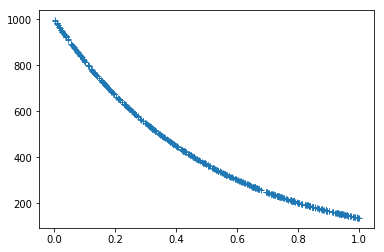

In [18]:
xmin,xmax = (0,1)
N = 500
xvals = np.random.uniform(xmin, xmax, N)
yvals0 = func0(xvals,a,b,c)
plt.plot(xvals, yvals0, '+')
plt.show()

In a second step we generate the error term errerr and add it to the previously computed values, storing the results in yvals

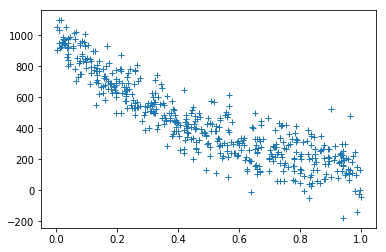

In [19]:
sig = 100.0
err = sig * np.random.standard_normal(N)
yvals = yvals0 + err
plt.plot(xvals, yvals, '+')
plt.show()

Fitting the curve

We now import the relvant module, and we now choose the functional relationship func between our x and y that is parameterised by three parameters a,b,ca,b,c of the curve we want to fit. We here use the same relationship as above, but obviously we can fit any curve we want (eg, linear, quadratic etc). We also have to provide an initial guess for the paramters, here ai,bi,ciai,bi,ci.

In [23]:
# import the curve fitting module and standard imports
from scipy.optimize import curve_fit 

In [24]:
# choose the function to be fitted... 
def func (x,a,b,c):
    return a*np.exp(-b*x)+c

# ...and provide initial estimates for the parameters
a0,b0,c0 = (0.5,0.5,0.5)

We now execute the curve fit and plot the results. The coefficients will be in the tuple coeffs=(a,b,c) and fiterr will contain an error estimate. If fiterr is NaN (or the algorithm terminates with too many iterations) this means that the algorithm did not converge, which means we need to adapt the initial values (see below)

a=10.05, b=0.05, c=0.05


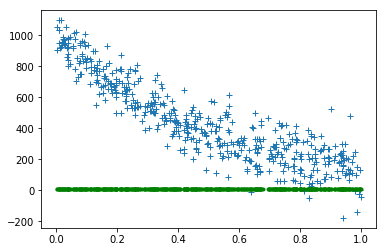

In [29]:
# manually fit the curve to obtain a viable set of starting parameters
at,bt,ct = (10.05,0.05,0.05)
plt.plot(xvals,yvals, '+')
plt.plot(xvals,func(xvals,at,bt,ct), 'g.')
print ("a=%s, b=%s, c=%s" % (at,bt,ct))

a=988.558265505, b=2.12249236609, c=25.8558307743


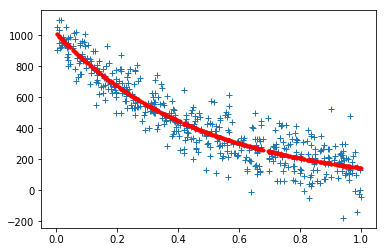

In [31]:
# exectute the curve fit...
coeffs, fiterr = curve_fit(func, xvals, yvals, p0=(at,bt,ct))

# ...and plot the results
print ("a=%s, b=%s, c=%s" % (coeffs[0], coeffs[1], coeffs[2]))
plt.plot(xvals,yvals, '+')
plt.plot(xvals,func(xvals,*coeffs),'r.')
plt.show()


In order to find the initial values we might want to plot the function with some initial parameters at,bt,ctat,bt,ct to allow for a rough manual fit